# Capítulo 9 – Detección de Anomalías con Transformers Autoencoders

En este capítulo se presenta el enfoque de **Transformers Autoencoders**, una arquitectura que combina la potencia de los **Transformers** con la filosofía de los **Autoencoders** para la detección de anomalías.

El modelo aprende a **reconstruir secuencias normales**, capturando dependencias de largo alcance mediante **mecanismos de atención** (*self-attention*).  
Cuando la entrada contiene un patrón anómalo que no se corresponde con lo aprendido, el error de reconstrucción aumenta y el sistema puede identificarlo.


## Motivación

¿Por qué utilizar Transformers en lugar de Autoencoders convencionales?

- Capturan **dependencias globales** entre elementos de la secuencia, no solo relaciones locales.  
- Han demostrado gran eficacia en problemas secuenciales (traducción, series temporales, NLP).  
- Se adaptan bien a contextos donde las correlaciones entre variables pueden variar a lo largo del tiempo.  
- Permiten un modelado flexible de series multivariantes, clave en aplicaciones industriales.


## Intuición

El **Transformer Autoencoder** consta de:

- **Encoder**: transforma la secuencia de entrada en una representación latente mediante capas de *multi-head self-attention*.  
- **Decoder**: reconstruye la secuencia original a partir de esa representación.  

De forma intuitiva:

> El modelo “aprende a copiar” secuencias normales atendiendo a dependencias a corto y largo plazo.  
> Cuando encuentra un comportamiento extraño, no logra reconstruirlo bien y el error aumenta.

## Arquitectura del Transformer Autoencoder

Dado un fragmento de serie temporal multivariante de longitud `T` con `F` variables,
$$
X \in \mathbb{R}^{T \times F},
$$
el TAE sigue estos pasos:

1. **Proyección de entrada**  
   Se mapea cada vector de características a una dimensión interna `d_model`:
   $$
   H_0 = \text{Linear}(X) \in \mathbb{R}^{T \times d_\text{model}}
   $$

2. **Positional Encoding (PE)**  
   Como el Transformer no es recurrente, añadimos información de orden:
   $$
   \tilde{H}_0 = H_0 + \text{PE}(T)
   $$

3. **Encoder (Self-Attention + FFN)**  
   Varias capas que permiten que cada instante “atienda” al resto para aprender dependencias globales:
   $$
   \text{memory} = \text{Encoder}(\tilde{H}_0)
   $$

4. **Decoder (Self-Attention + Cross-Attention + FFN)**  
   El *decoder* recibe una consulta (p.ej., la propia secuencia embebida) y **atiende** a la *memory* del encoder
   para **reconstruir**:
   $$
   \tilde{H}_\text{dec} = \text{Decoder}(\tilde{H}_0, \text{memory})
   $$

5. **Capa de salida**  
   - **Opción A (sec2sec):** reconstruir toda la secuencia $$\hat{X} \in \mathbb{R}^{T \times F}$$.  
   - **Opción B (último paso):** reconstruir sólo el último *timestep* $$\hat{x}_{T} \in \mathbb{R}^{F}$$.

En este capítulo seguiremos la **Opción B**, muy utilizada en la práctica (e.g., TranAD-like): se entrena a reconstruir el **último paso** a partir de la ventana completa → útil para **detección inmediata** del estado actual.



## Versión simplificada del Transformer Autoencoder

Antes de usar la implementación más completa, vamos a construir un modelo **minimalista** 
construido directamente con los bloques de PyTorch:

- `nn.TransformerEncoderLayer`  
- `nn.TransformerDecoderLayer`  

Este modelo reconstruirá el **último paso de la secuencia** a partir de las ventanas de entrada.  
Así podremos ver de forma clara cómo funciona la idea central.


In [79]:
import torch.nn as nn
import torch

class SimpleTransformerAE(nn.Module):
    def __init__(self, input_dim, seq_len, d_model=32, nhead=2, dropout=0.1):
        super().__init__()
        self.seq_len = seq_len
        self.input_proj = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True, dropout=dropout
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)

        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, x):
        # Encoder
        z = self.input_proj(x)              # [B, seq_len, d_model]
        memory = self.encoder(z)            # [B, seq_len, d_model]

        # Decoder: query = vector nulo para "pedir" reconstrucción
        query = torch.zeros(x.size(0), 1, z.size(-1), device=x.device)
        out = self.decoder(query, memory)   # [B, 1, d_model]

        x_hat = self.output_layer(out.squeeze(1))  # [B, input_dim]
        return x_hat



## Ejemplo ilustrativo con Transformer Autoencoder

Para entender la naturaleza de este modelo, vamos a construir un **ejemplo sencillo**:

1. Creamos una secuencia **normal** (ondas sinusoidales correlacionadas).  
2. Insertamos un **fallo puntual** en una de las señales.  
3. Entrenamos un Transformer Autoencoder simplificado **solo con datos normales**.  
4. Comparamos los errores de reconstrucción en segmentos normales vs. anómalos.

La idea es que el modelo “aprende a copiar” las relaciones habituales.  
Cuando éstas se rompen, la reconstrucción falla y el error se dispara.


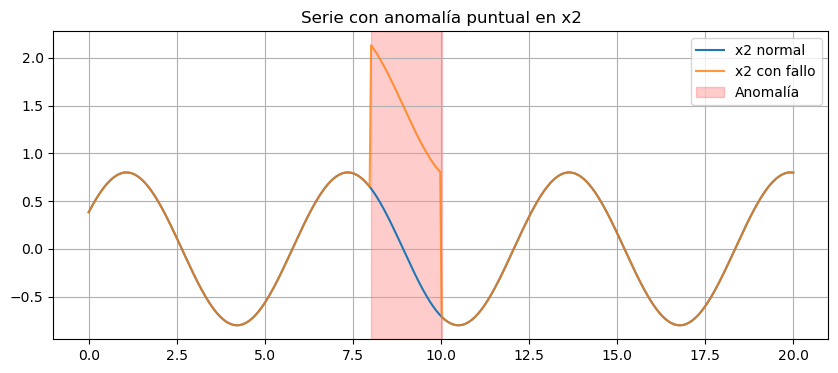

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Datos sintéticos para el ejemplo
t = np.linspace(0, 20, 500)
x1 = np.sin(t)
x2 = np.sin(t + 0.5) * 0.8

# Introducimos fallo puntual en x2
x2_fault = x2.copy()
x2_fault[200:250] += 1.5

X_norm = np.vstack([x1, x2]).T
X_anom = np.vstack([x1, x2_fault]).T

plt.figure(figsize=(10,4))
plt.plot(t, x2, label="x2 normal")
plt.plot(t, x2_fault, label="x2 con fallo", alpha=0.8)
plt.axvspan(t[200], t[250], color="red", alpha=0.2, label="Anomalía")
plt.legend(); plt.title("Serie con anomalía puntual en x2"); plt.grid(True)
plt.show()


## Entrenamiento del modelo en datos normales

Usaremos el `SimpleTransformerAE` definido antes.  
El entrenamiento se realiza únicamente con los segmentos **normales** (sin anomalías).  

Así, el modelo aprende a reconstruir correctamente el último paso de cada ventana normal.


In [81]:
import torch
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_windows(X, seq_len):
    n_samples = X.shape[0] - seq_len + 1
    windows = np.array([X[i:i+seq_len] for i in range(n_samples)])
    return windows

seq_len = 10

# Preparamos datos (solo normales)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)
X_train_win = create_windows(X_train, seq_len=seq_len)

# Tensor
X_tensor = torch.tensor(X_train_win, dtype=torch.float32).to(device)

# Modelo simplificado
model_simple = SimpleTransformerAE(input_dim=2, seq_len=seq_len).to(device)
optimizer = optim.Adam(model_simple.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Entrenamiento
for epoch in range(150):
    model_simple.train()
    optimizer.zero_grad()
    x_hat = model_simple(X_tensor)
    loss = criterion(x_hat, X_tensor[:, -1, :])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss={loss.item():.6f}")


Epoch 0 | Loss=0.849747
Epoch 10 | Loss=0.214481
Epoch 20 | Loss=0.130758
Epoch 30 | Loss=0.078146
Epoch 40 | Loss=0.032166
Epoch 50 | Loss=0.029787
Epoch 60 | Loss=0.026547
Epoch 70 | Loss=0.022177
Epoch 80 | Loss=0.019670
Epoch 90 | Loss=0.017633
Epoch 100 | Loss=0.014850
Epoch 110 | Loss=0.011580
Epoch 120 | Loss=0.010035
Epoch 130 | Loss=0.008181
Epoch 140 | Loss=0.006790


## Reconstrucción en presencia de anomalías

Una vez entrenado el modelo con datos normales, vamos a darle como entrada
la serie que contiene un fallo en `x2`.

Lo que esperamos ver es:

- En los tramos normales → la reconstrucción es bastante precisa.  
- En el intervalo anómalo → el modelo **no consigue reproducir bien** la señal.  


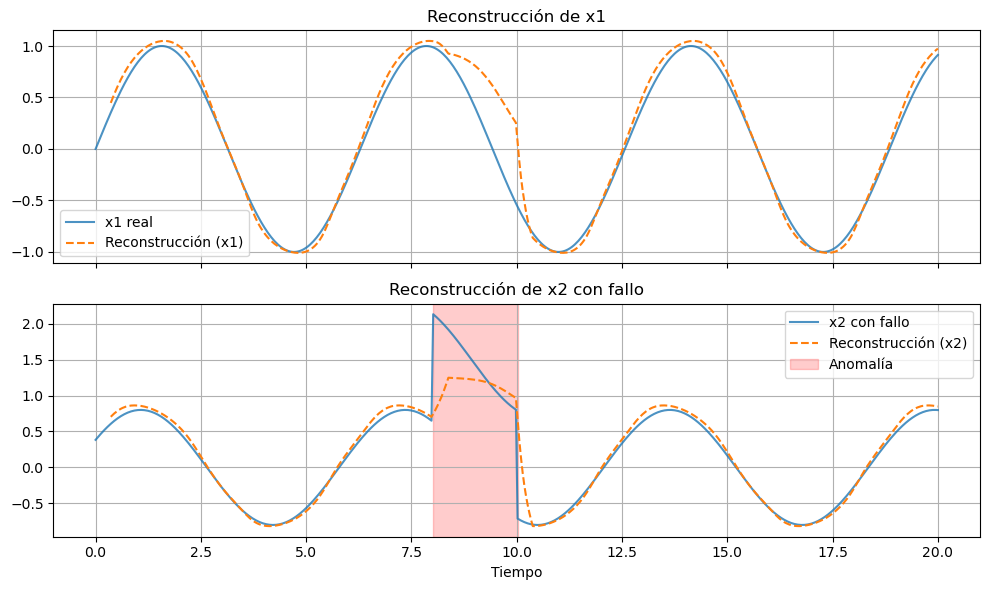

In [82]:
# Preparamos datos con anomalía

X_all = np.vstack([x1, x2_fault]).T
X_scaled = scaler.transform(X_all)
X_win_all = create_windows(X_scaled, seq_len=seq_len)
X_tensor_all = torch.tensor(X_win_all, dtype=torch.float32).to(device)

# Reconstrucción
model_simple.eval()
with torch.no_grad():
    recon = model_simple(X_tensor_all).cpu().numpy()

# Volvemos al espacio original (inversa del MinMaxScaler)
recon_inv = scaler.inverse_transform(recon)

fig, axs = plt.subplots(2, 1, figsize=(10,6), sharex=True)

# --- Señal x1 ---
axs[0].plot(t, x1, label="x1 real", alpha=0.8)
axs[0].plot(t[seq_len-1:], recon_inv[:,0], label="Reconstrucción (x1)", linestyle="--")
axs[0].set_title("Reconstrucción de x1")
axs[0].legend()
axs[0].grid(True)

# --- Señal x2 ---
axs[1].plot(t, x2_fault, label="x2 con fallo", alpha=0.8)
axs[1].plot(t[seq_len-1:], recon_inv[:,1], label="Reconstrucción (x2)", linestyle="--")
axs[1].axvspan(t[200], t[250], color="red", alpha=0.2, label="Anomalía")
axs[1].set_title("Reconstrucción de x2 con fallo")
axs[1].legend()
axs[1].grid(True)

plt.xlabel("Tiempo")
plt.tight_layout()
plt.show()



Aunque la anomalía está inyectada únicamente en x2, observamos que también puede afectar de forma indirecta a la reconstrucción de x1.
Esto ocurre porque el autoencoder aprendió la correlación normal entre ambas señales: cuando una se rompe, la representación latente conjunta se distorsiona y la reconstrucción de la otra variable también puede perder precisión.

## Error de reconstrucción en el tiempo

Ahora calculamos el **error cuadrático medio** entre la señal original y la reconstruida.
Este error actuará como nuestro **score de anomalía**.

La expectativa es que:
- En zonas normales → error bajo y estable.  
- En el intervalo anómalo → error mucho más alto.  


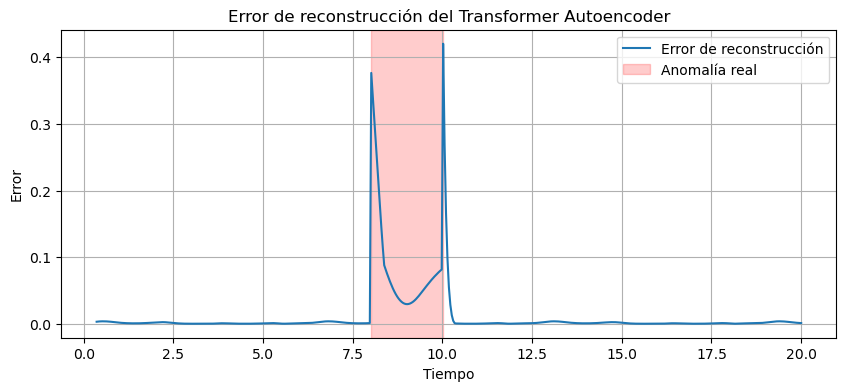

In [83]:
# Error de reconstrucción
errors = np.mean((X_win_all[:,-1,:] - recon)**2, axis=1)

plt.figure(figsize=(10,4))
plt.plot(t[seq_len-1:], errors, label="Error de reconstrucción")
plt.axvspan(t[200], t[250], color="red", alpha=0.2, label="Anomalía real")
plt.title("Error de reconstrucción del Transformer Autoencoder")
plt.xlabel("Tiempo"); plt.ylabel("Error")
plt.legend(); plt.grid(True); plt.show()


## Comparación de errores por variable

Hasta ahora hemos visto el error de reconstrucción total (media sobre todas las variables).  
Sin embargo, el Transformer Autoencoder procesa varias señales al mismo tiempo y **cada variable puede tener errores distintos**.

Vamos a calcular y visualizar el error de reconstrucción **por cada variable**.
Esto nos permitirá comprobar que la anomalía está localizada en `x2`, mientras que `x1` se reconstruye sin problema.


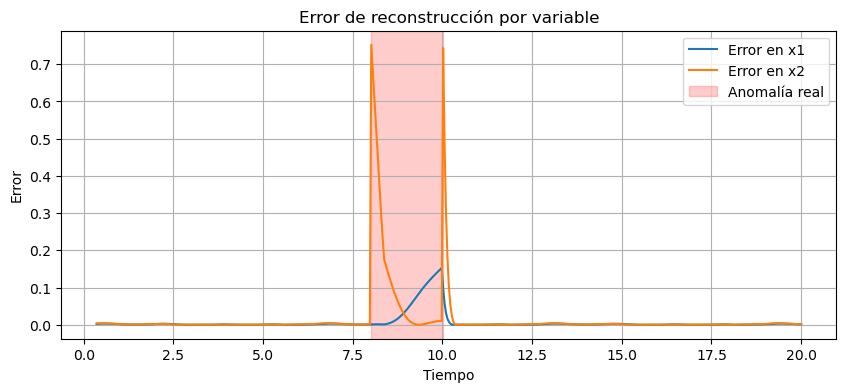

In [84]:
# Error separado por variable
errors_vars = (X_win_all[:,-1,:] - recon)**2

plt.figure(figsize=(10,4))
plt.plot(t[seq_len-1:], errors_vars[:,0], label="Error en x1")
plt.plot(t[seq_len-1:], errors_vars[:,1], label="Error en x2")
plt.axvspan(t[200], t[250], color="red", alpha=0.2, label="Anomalía real")
plt.title("Error de reconstrucción por variable")
plt.xlabel("Tiempo"); plt.ylabel("Error")
plt.legend(); plt.grid(True); plt.show()


### Dependencias de largo alcance

El Transformer Encoder es capaz de capturar **dependencias a gran distancia** dentro de la secuencia.  
Para comprobarlo, construimos un ejemplo donde `x2` es simplemente una copia retrasada de `x1` en 50 pasos.

- Un modelo basado solo en relaciones locales (ej. convoluciones pequeñas) tendría dificultades.  
- El Transformer, gracias a su mecanismo de atención global, puede relacionar `x2` con pasos muy anteriores y reconstruirlo correctamente.


Epoch 0 | Loss=0.853431
Epoch 100 | Loss=0.021554
Epoch 200 | Loss=0.005153
Epoch 300 | Loss=0.002939
Epoch 400 | Loss=0.002586


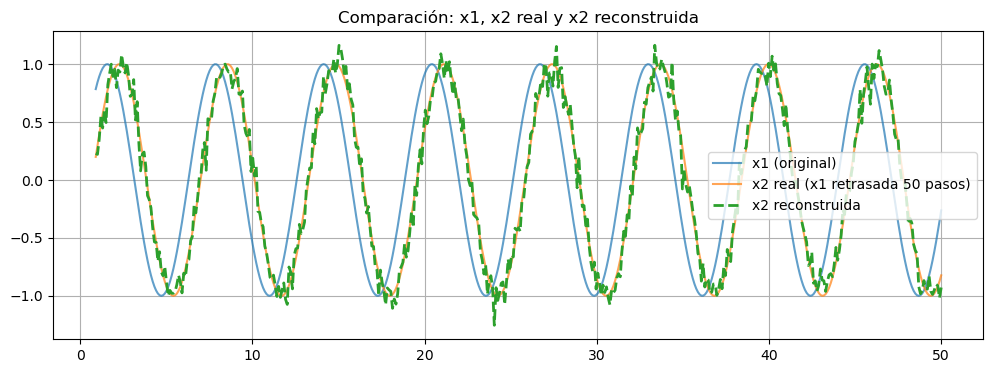

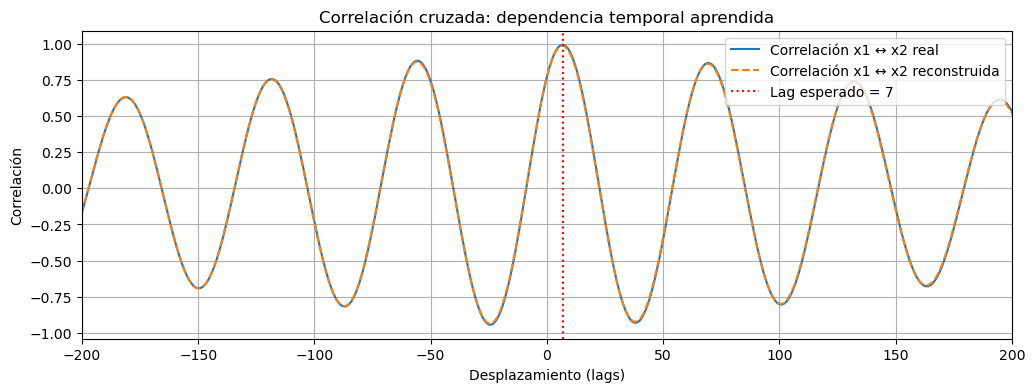

In [85]:
# Creamos una señal con dependencias largas
t = np.linspace(0, 50, 500)
x1 = np.sin(t)
x2 = np.roll(x1, 7)  # x2 es la misma señal pero desplazada 7 pasos

seq_len = 10  # Secuencia más larga para captar la dependencia

X_longdep = np.vstack([x1, x2]).T
X_train = scaler.fit_transform(X_longdep)
X_win = create_windows(X_train, seq_len=seq_len)
X_tensor = torch.tensor(X_win, dtype=torch.float32).to(device)

model_simple = SimpleTransformerAE(input_dim=2, seq_len=seq_len).to(device)
optimizer = optim.Adam(model_simple.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(500):
    model_simple.train()
    optimizer.zero_grad()
    x_hat = model_simple(X_tensor)
    loss = criterion(x_hat, X_tensor[:, -1, :])
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss={loss.item():.6f}")

# Reconstrucción con el modelo simple ya entrenado
with torch.no_grad():
    recon = model_simple(X_tensor).cpu().numpy()
recon_inv = scaler.inverse_transform(recon)

from scipy.signal import correlate

# Usamos la parte de x1 que corresponde a la reconstrucción
x1_aligned = x1[seq_len-1:] 
x2_real_aligned = x2[seq_len-1:]
x2_recon = recon_inv[:,1]

# --- Comparación visual ---
plt.figure(figsize=(12,4))
plt.plot(t[seq_len-1:], x1[seq_len-1:], label="x1 (original)", alpha=0.7)
plt.plot(t[seq_len-1:], x2[seq_len-1:], label="x2 real (x1 retrasada 50 pasos)", alpha=0.7)
plt.plot(t[seq_len-1:], x2_recon, "--", label="x2 reconstruida", linewidth=2)
plt.legend()
plt.title("Comparación: x1, x2 real y x2 reconstruida")
plt.grid(True)
plt.show()

# --- Correlación cruzada ---
lags = np.arange(-200, 201)

n = min(len(x1_aligned), len(x2_recon))
x1_aligned = x1_aligned[:n]
x2_real_aligned = x2_real_aligned[:n]
x2_recon = x2_recon[:n]


corr_real = correlate(x2_real_aligned - x2_real_aligned.mean(),
                      x1_aligned - x1_aligned.mean(), mode="full")
corr_recon = correlate(x2_recon - x2_recon.mean(),
                       x1_aligned - x1_aligned.mean(), mode="full")

# Normalizamos
corr_real = corr_real / (np.std(x2_real_aligned) * np.std(x1_aligned) * len(x1_aligned))
corr_recon = corr_recon / (np.std(x2_recon) * np.std(x1_aligned) * len(x1_aligned))

# Eje de retardos (lags)
lags_corr = np.arange(-len(x1_aligned)+1, len(x1_aligned))

plt.figure(figsize=(12,4))
plt.plot(lags_corr, corr_real, label="Correlación x1 ↔ x2 real")
plt.plot(lags_corr, corr_recon, "--", label="Correlación x1 ↔ x2 reconstruida")
plt.axvline(7, color="red", linestyle=":", label="Lag esperado = 7")
plt.xlim(-200, 200)
plt.legend()
plt.title("Correlación cruzada: dependencia temporal aprendida")
plt.xlabel("Desplazamiento (lags)")
plt.ylabel("Correlación")
plt.grid(True)
plt.show()



> La señal reconstruida presenta cierto **ruido** porque el Transformer usado es un modelo muy simple (pocas capas, poca capacidad y entrenado con pocos datos). Aun así, logra **clavar correctamente el desfase** de la dependencia temporal, lo que demuestra que capta la relación entre `x1` y `x2` aunque la salida no sea perfectamente suave.


### Robustez frente a ruido local

Otra propiedad interesante es que el Transformer **no depende de un único paso**, 
sino que combina información de toda la ventana.  

Si en un segmento inyectamos **ruido fuerte** sobre `x2`:

- El modelo consigue mantener una reconstrucción bastante fiel de la señal subyacente.  
- Esto ocurre porque el mecanismo de atención pondera otros pasos de la secuencia, 
  en lugar de dejarse arrastrar completamente por el ruido puntual.


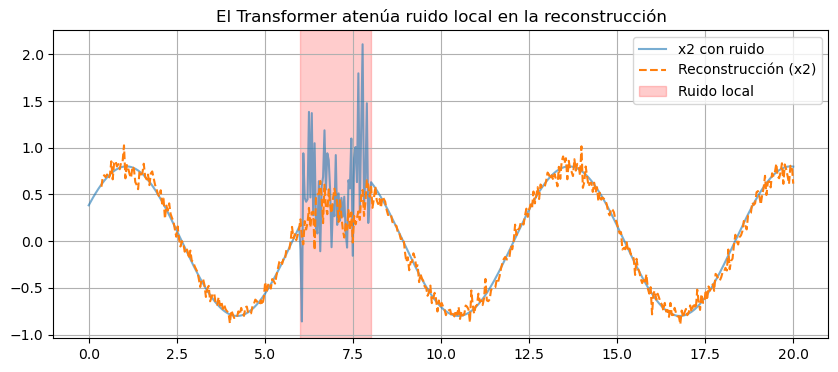

In [86]:
# Señal normal
t = np.linspace(0, 20, 500)
x1 = np.sin(t)
x2 = np.sin(t + 0.5) * 0.8
X_norm = np.vstack([x1, x2]).T

seq_len = 10

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_norm)
X_win = create_windows(X_train, seq_len=seq_len)
X_tensor = torch.tensor(X_win, dtype=torch.float32).to(device)

model_simple = SimpleTransformerAE(input_dim=2, seq_len=seq_len).to(device)
optimizer = optim.Adam(model_simple.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(500):
    model_simple.train()
    optimizer.zero_grad()
    x_hat = model_simple(X_tensor)
    loss = criterion(x_hat, X_tensor[:, -1, :])
    loss.backward()
    optimizer.step()


# --- Test con ruido ---
x2_noisy = x2.copy()
x2_noisy[150:200] += np.random.normal(0, 0.5, size=50)

X_noisy = np.vstack([x1, x2_noisy]).T
X_noisy_scaled = scaler.transform(X_noisy)          
X_win_noisy = create_windows(X_noisy_scaled, seq_len=seq_len)
X_tensor_noisy = torch.tensor(X_win_noisy, dtype=torch.float32).to(device)

with torch.no_grad():
    recon = model_simple(X_tensor_noisy).cpu().numpy()
recon_inv = scaler.inverse_transform(recon)



plt.figure(figsize=(10,4))
plt.plot(t, x2_noisy, label="x2 con ruido", alpha=0.6)
plt.plot(t[seq_len-1:], recon_inv[:,1], linestyle="--", label="Reconstrucción (x2)")
plt.axvspan(t[150], t[200], color="red", alpha=0.2, label="Ruido local")
plt.legend(); plt.title("El Transformer atenúa ruido local en la reconstrucción")
plt.grid(True); plt.show()


>La reconstrucción contiene algo de **ruido residual** porque el modelo genera cada paso a partir de ventanas solapadas y con capacidad limitada (solo una capa y pocas cabezas de atención).  
Aunque el Transformer logra capturar la correlación principal y suavizar gran parte del ruido inyectado, las pequeñas inconsistencias entre ventanas provocan una señal reconstruida menos suave que la original.


### Anomalía estructural

Finalmente, probamos una anomalía más grave: un **cambio de fase** en la señal `x2`.  

En este caso:
- La correlación normal entre `x1` y `x2` se rompe de forma persistente.  
- El Transformer Autoencoder, entrenado solo con patrones normales, 
  no logra reconstruir bien esa nueva dinámica.  
- El error de reconstrucción crece claramente en la zona anómala, lo que permite detectarla.

Este ejemplo muestra cómo el modelo es sensible a **rupturas estructurales**, 
no solo a ruido o desviaciones puntuales.


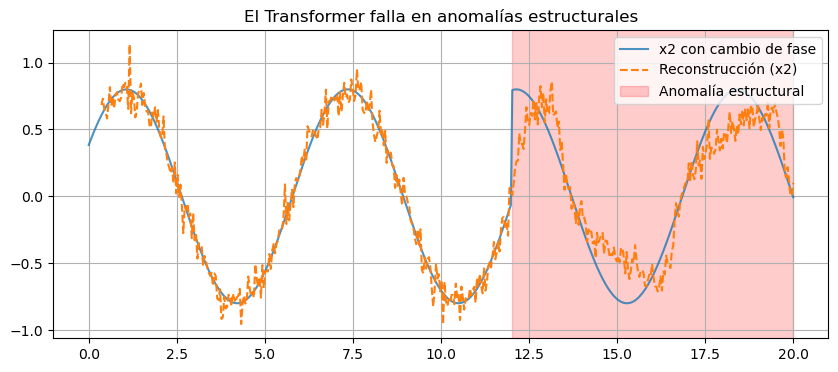

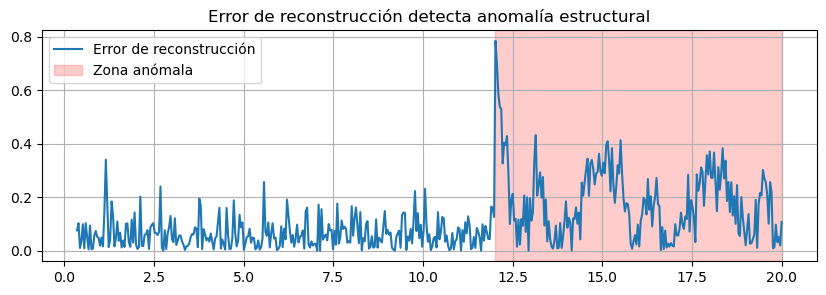

In [78]:
# Señal normal correlacionada
t = np.linspace(0, 20, 500)
x1 = np.sin(t)
x2 = np.sin(t + 0.5) * 0.8

# Anomalía estructural: x2 cambia de fase drásticamente
x2_phase = x2.copy()
x2_phase[300:] = np.sin(t[300:] + 2.0) * 0.8

X_phase = np.vstack([x1, x2_phase]).T
X_scaled = scaler.transform(X_phase)
X_win = create_windows(X_scaled, seq_len=seq_len)
X_tensor = torch.tensor(X_win, dtype=torch.float32).to(device)

with torch.no_grad():
    recon = model_simple(X_tensor).cpu().numpy()
recon_inv = scaler.inverse_transform(recon)

plt.figure(figsize=(seq_len,4))
plt.plot(t, x2_phase, label="x2 con cambio de fase", alpha=0.8)
plt.plot(t[seq_len-1:], recon_inv[:,1], linestyle="--", label="Reconstrucción (x2)")
plt.axvspan(t[300], t[-1], color="red", alpha=0.2, label="Anomalía estructural")
plt.legend(); plt.title("El Transformer falla en anomalías estructurales")
plt.grid(True); plt.show()

error = np.abs(x2_phase[seq_len-1:] - recon_inv[:,1])

plt.figure(figsize=(seq_len,3))
plt.plot(t[seq_len-1:], error, label="Error de reconstrucción")
plt.axvspan(t[300], t[-1], color="red", alpha=0.2, label="Zona anómala")
plt.legend(); plt.title("Error de reconstrucción detecta anomalía estructural")
plt.grid(True); plt.show()

> La reconstrucción presenta cierto **ruido** incluso en las zonas normales.  
Esto ocurre porque el Transformer usado es muy simple (una sola capa, poca
capacidad y entrenado con pocos datos). El modelo capta correctamente la
tendencia global y detecta el cambio de fase, pero la salida no es perfectamente
suave al no disponer de la complejidad suficiente para modelar con precisión
las señales en todo el rango temporal.



## Conclusión

Los Transformers Autoencoders llevan la idea clásica de reconstrucción de los Autoencoders
a un nivel superior al incorporar **mecanismos de atención**.

Esto les permite:

- Capturar **dependencias a largo plazo** en series temporales.  
- Ser más robustos frente a **ruido local o puntual**.  
- Detectar anomalías cuando las **correlaciones estructurales** entre variables se rompen.  

En comparación con Autoencoders convencionales, los Transformers resultan especialmente
adecuados en contextos industriales multivariantes donde los fallos pueden manifestarse
en patrones complejos y no locales.  

Su mayor coste computacional se justifica cuando las relaciones temporales y entre variables
son demasiado ricas como para ser capturadas con arquitecturas más simples.


### Referencias

[1] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017).  
**Attention Is All You Need.**  
*Advances in Neural Information Processing Systems (NeurIPS).*  

[2] Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021).  
**Temporal Fusion Transformers for Interpretable Multi-horizon Time Series Forecasting.**  
*International Journal of Forecasting.*  

[3] Tuli, S., Casale, G., & Jennings, N. R. (2022).  
**TranAD: Deep Transformer Networks for Anomaly Detection in Multivariate Time Series Data.**  
*Proceedings of VLDB 2022.*  
Disponible en: [https://github.com/imperial-qore/TranAD](https://github.com/imperial-qore/TranAD)  

[4] Xu, J., Chen, H., & Ren, P. (2021).  
**Anomaly Transformer: Time Series Anomaly Detection with Association Discrepancy.**  
*Advances in Neural Information Processing Systems (NeurIPS).*  
